In [1]:
from simulator import NetworkSimulator
from matplotlib import pyplot as plt
from random import choice
import random
import collections

In [2]:
class QPacketRouter():
 
  #called
  def __init__(self, simulator, dropped_penalty=0.01, epsilon=0.05, learning_rate=0.01):
    self.simulator=simulator

    # stores the Q value for a src, dest, neighbour combination (complex key)
    self.Q = collections.defaultdict(float)

    # to decide between exploration and exploitation
    self.epsilon = epsilon
    self.learning_rate = learning_rate
    self.dropped_penalty = dropped_penalty



  # returns best next step for packet from src to dst for min Q
  # handles dropped nodes, since it only checks Q values of neighbours currently in the graph
  def min_Q(self, src, dst):
    
    src_neighbours = self.simulator.G.neighbors(src)

    # initial Q val and node
    min_Q = float('inf')
    min_node = None

    for neighbor in src_neighbours:
      if self.Q[(src, dst, neighbor)] < min_Q:
        min_Q = self.Q[(src, dst, neighbor)] #0
        min_node = neighbor #A
    return min_node, min_Q

 
  def update_Q(self, cur, nxt, packet):
    # estimated time remaining from next node.
    min_node, min_q = self.min_Q(nxt, packet.dst)

    travel_time = self.simulator.traverseEdge(packet, cur, nxt)

    if packet.dropped:
      # Penalize the Q score as a quadratic function of the number of packets
      # dropped along this edge so far.
      edge_attr = self.simulator.get_edge_attr(cur, nxt)
      min_node, min_q = self.min_Q(packet.src, packet.dst)
      
      min_q *= 1. + self.dropped_penalty * (edge_attr.dropped_packets ** (1/3))
 
    self.Q[(cur, packet.dst, nxt)] += self.learning_rate * (min_q + travel_time - self.Q[(cur, packet.dst, nxt)])
    return None if packet.dropped else nxt
 


  def routePacketSingleStep(self, packet, cur):
    if random.random() < self.epsilon:
      nxt = choice(list(self.simulator.G.neighbors(cur)))
    else:
      nxt, _ = self.min_Q(cur, packet.dst)
 
    return self.update_Q(cur, nxt, packet)

In [3]:
nodes = 25
packets = 50000

In [4]:
def get_averages(total_times, packet_count):
    get_avg=[]
    for i in range(int(len(total_times)/packet_count)):
        get_avg.append(sum(total_times[i*packet_count:(i+1)*packet_count])/packet_count)

    return get_avg

In [5]:
n_s = NetworkSimulator(nodes)
q_packet_router = QPacketRouter(n_s)

# testpacket- is a list
test_packets = n_s.generate_packets(packets)


packet_count = 100



print("Q-Routing:")
n_s.train_Q(test_packets, q_packet_router)

total_times = [packet.totalTime for packet in test_packets]
q_average_times = get_averages(total_times, packet_count)

Q-Routing:
 avg path length:       8.649380
 avg transmission time: 840.624382
 total dropped packets :   17379


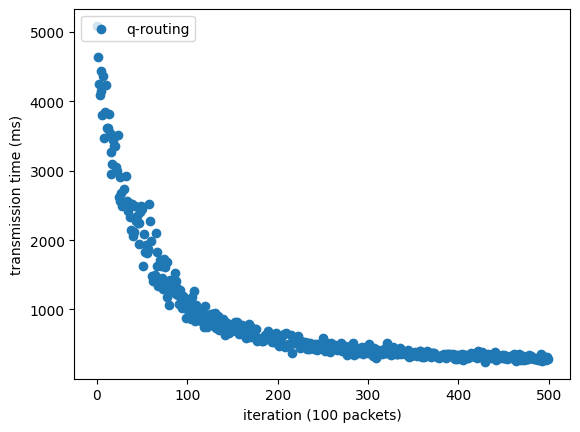

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(range(len(q_average_times)), q_average_times, label="q-routing")
plt.legend(loc='upper left')
plt.ylabel("transmission time (ms)")
plt.xlabel("iteration (100 packets)")
plt.savefig('qrouting.png', dpi=300)